## Overview
This notebook is used to generate various test vectors to support FALCON Digital Signal Processing unit tests. Vectors include: raw complex input data and raw complex output data.

## Constants
This notebook supports configurable behavior through environment variables, which in turn modify the notebook-level constants specified here.

In [17]:
import copy
import logging
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
from scipy import signal
import struct

In [21]:
NUM_INPUT_TONES_STR = os.environ.get('NUM_TONES', '4')
INPUT_SAMPLE_RATE_STR = os.environ.get('INPUT_SAMPLE_RATE', '1000000')
NUM_OUTPUT_SAMPLES_STR = os.environ.get('NUM_OUTPUT_SAMPLES', '1000000')
VERBOSE_LOGGING_STR = os.environ.get('VERBOSE', '0')
OUTPUT_FILE_BASE_NAME = os.environ.get('OUT_FILE_NAME', 'multi_chan_freq_shift_test_vector')
SEED_STR = os.environ.get('SEED', '2020')

# convert from the string environment variables to other, more convenient, representations
NUM_TONES = int(NUM_INPUT_TONES_STR)
INPUT_SAMPLE_RATE = np.array([INPUT_SAMPLE_RATE_STR], dtype=np.float64)
NUM_OUTPUT_SAMPLES = int(NUM_OUTPUT_SAMPLES_STR)
RANDOM_SEED = int(SEED_STR)

INPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_x.bin"
OUTPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_y_shift_%d_hz.bin"

VERBOSE_LOGGING = True
if VERBOSE_LOGGING_STR is not "1":
    VERBOSE_LOGGING = False

## Logging
Use the Python *logging* module for basic logging. Configure the logging level based on the provided command-line arguments.

In [6]:
logging_level = logging.INFO
if VERBOSE_LOGGING:
    logging_level = logging.DEBUG
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging_level)

In [7]:
logging.info("####################")
logging.info("# NUM_TONES               = %u" % (NUM_TONES))
logging.info("# INPUT_SAMPLE_RATE       = %f" % (INPUT_SAMPLE_RATE))
logging.info("# NUM_OUTPUT_SAMPLES      = %u" % (NUM_OUTPUT_SAMPLES))
logging.info("# INPUT_FILE_NAME         = %s" % (INPUT_VEC_FILE_NAME))
logging.info("# OUTPUT_FILE_NAME        = %s" % (OUTPUT_VEC_FILE_NAME))
logging.info("####################")

INFO:####################
INFO:# NUM_TONES               = 4
INFO:# INPUT_SAMPLE_RATE       = 1000000.000000
INFO:# NUM_OUTPUT_SAMPLES      = 1000000
INFO:# INPUT_FILE_NAME         = multi_chan_freq_shift_test_vector_x_%03u.bin
INFO:# OUTPUT_FILE_NAME        = multi_chan_freq_shift_test_vector_y_%03u.bin
INFO:####################


## Create a Complex Sinusoid

In [14]:
SIGNAL_SCALE = 2048
NUM_INPUT_SAMPLES = NUM_OUTPUT_SAMPLES
TONE_FREQS = []

# set the numpy random seed so that the output files are repeatable
np.random.seed(RANDOM_SEED)

t = np.arange(0, NUM_INPUT_SAMPLES, dtype=np.float64)
logging.info("Time (t) vector requires %.3f mega bytes" % (t.nbytes / 1024.0 / 1024.0))

# create a single tone at the center frequency
x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(INPUT_SAMPLE_RATE/INPUT_SAMPLE_RATE))

num_negative_tones = np.random.randint(0, NUM_TONES)
num_positive_tones = NUM_TONES - num_negative_tones

# add negative freq tones outside the passband
for tone_idx in range(num_negative_tones):
    
    tone_freq = int(np.random.randint(-1 * ((INPUT_SAMPLE_RATE / 2) / 100), 0) * 100)
    TONE_FREQS.append(tone_freq)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add positive freq tones outside the passband
for tone_idx in range(num_positive_tones):
    
    tone_freq = int(np.random.randint(0, ((INPUT_SAMPLE_RATE / 2) / 100)) * 100)
    TONE_FREQS.append(tone_freq)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add a small amount of noise
noise_power = 0.001 * INPUT_SAMPLE_RATE / 2
x += np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

logging.info("Input (x) vector created with %u tones outside passband" % (NUM_TONES * 2))

INFO:Time (t) vector requires 7.629 mega bytes
INFO:Input (x) vector created with 8 tones outside passband


Plot the vector

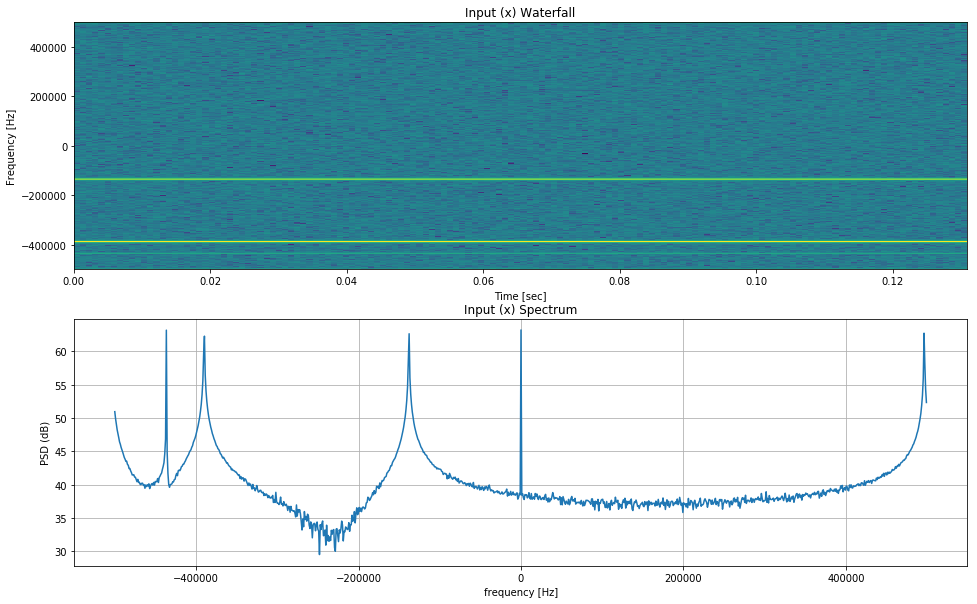

In [15]:
FFT_SIZE = 1024
NUM_FFTS = 128
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
Pxx, freqs, bins, im = plt.specgram(x[:FFT_SIZE*NUM_FFTS], NFFT=FFT_SIZE, Fs=INPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Input (x) Waterfall')

plt.subplot(2,1,2)

psd = np.abs(np.fft.fftshift(np.fft.fft(x[:FFT_SIZE], FFT_SIZE)))
psd = 10 * np.log10(psd)
freqs = np.arange(-1 * (INPUT_SAMPLE_RATE / 2), (INPUT_SAMPLE_RATE / 2), INPUT_SAMPLE_RATE / FFT_SIZE, dtype=np.float64)
plt.plot(freqs, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.title('Input (x) Spectrum')
plt.grid(True)

### Save the Input Vectors

In [ ]:
# convert the input vector to float32
x = x.astype(np.complex64)

# save the input "x" vector file
input_vec_file = open(INPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for idx in range(len(x)):
    
    real_val = int(x[idx].real)
    imag_val = int(x[idx].imag)
    
    # pack as little endian format using shorts (int16_t)
    input_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    x[idx] = real_val + 1j * imag_val
    
    num_samples_processed += 1
    
input_vec_file.close()

### Create the Output Vectors

In [22]:
for file_idx in range(len(TONE_FREQS)):
    
    freq_shift = TONE_FREQS[file_idx]
    shifted_y = copy.deepcopy(x)
    
    rollover_idx_float = INPUT_SAMPLE_RATE / abs(freq_shift)
    logging.info("Calculated float rollover index %.16f" % (rollover_idx_float))

    while rollover_idx_float < 1e4:
        rollover_idx_float = rollover_idx_float * 10.0

    logging.info("Adjusted float rollover index to %.16f" % (rollover_idx_float))
    
    rollover_idx = np.round(rollover_idx_float)
    logging.info("Computed max integer rollover index %u" % (rollover_idx))

    t = np.arange(0, len(shifted_y), dtype=np.float32)
    for ii in range(len(shifted_y)):
        t[ii] = ii % rollover_idx
    
    angular_freq = 2.0 * np.pi * (freq_shift/INPUT_SAMPLE_RATE)
    logging.info("Computed angular freq:%.16f" % (angular_freq))
    
    fs_vec = np.exp(1j * t * angular_freq)
    fs_vec = fs_vec.astype(np.complex64)
    
    shifted_y = shifted_y * fs_vec
    
    # save the output "y" vector file
    output_vec_file = open(OUTPUT_VEC_FILE_NAME % (freq_shift), 'wb')

    num_samples_processed = 0
    for val in shifted_y:
    
        real_val = int(val.real)
        imag_val = int(val.imag)
    
        # pack as little endian format using shorts (int16_t)
        output_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
        num_samples_processed += 1
    
    output_vec_file.close()
    

INFO:Calculated float rollover index 2.2907303306440161
INFO:Adjusted float rollover index to 229073.0330644015921280
INFO:Computed max integer rollover index 229073
INFO:Calculated float rollover index 2.5641551621571725
INFO:Adjusted float rollover index to 256415.5162157172453590
INFO:Computed max integer rollover index 256416
INFO:Calculated float rollover index 7.2481625907832363
INFO:Adjusted float rollover index to 724816.2590783236082643
INFO:Computed max integer rollover index 724816
INFO:Calculated float rollover index 2.0147236000693063
INFO:Adjusted float rollover index to 201472.3600069305975921
INFO:Computed max integer rollover index 201472
